In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pprint, math, random, inspect, numbers

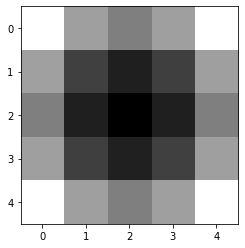

In [9]:
def create_img(fn,**kwarg):
    """ creates a square image in the form of a sz*sz element list vector """
    sz = kwarg.get('sz',5)
    img = [float(fn(c,r,**kwarg)) for c in range(sz) for r in range(sz)]
    return img

def uniform_noise(delta=1e-3):    
    return delta*(random.random()-0.5)

def dist_sq(r,c,sz=5):
    return ((r-sz//2)**2 + (c-sz//2)**2)

def quadratic(r,c,sz=5,noise=True):
    scale = float(sz*sz)
    v = dist_sq(r,c,sz)/scale
    return v + (uniform_noise() if noise else 0.)

def gauss(r,c,sz=5,sigma=1.0):
    return math.exp(-dist_sq(r,c,sz)/sigma)

def gabor(r,c,sz=5,sigma=1.0,kx=1.0,ky=0.0,phase=0.0):    
    wave = r*kx + c*ky
    mod = (1.-phase)*math.sin(wave)
    mod += phase*math.cos(wave)
    return mod*math.exp(-dist_sq(r,c,sz)/sigma)

%matplotlib inline
def show_img(img):
    sz = int(math.ceil(math.sqrt(len(img))))
    plt.imshow([[img[r*sz+c] for c in range(sz)] for r in range(sz)], cmap='gray')
    
quad_img = create_img(quadratic,sz=5)
gauss_img = create_img(gauss,sz=15,sigma=3.0)
gabor_img = create_img(gabor,sz=20,sigma=5.0,phase=1.0)

show_img(quad_img)

In [48]:
# %debug "create_img(sz, quadratic, dump=False)"

In [12]:
def mean_pixel_value_for_img(img):
    return sum(img)/float(len(img))

def num_grad(fn, v, delta=1.e-1):
    """
    """
    assert(len(v) > 0)
    for x in v: 
        assert isinstance(x, numbers.Number)
    fn_v = fn(v)
    def partial(n):
        delta_v = [x for x in v]
        delta_v[n] += delta   
        fn_delta_v = fn(delta_v)
        return (fn_delta_v - fn_v)/delta    
    jac = [partial(n) for n in range(len(v))]
    return jac

In [11]:
def calc_bins(img, width=.1):
    """ calculate the bin boundaries for an image """
    min_px, max_px = min(img), max(img)
    min_bin = math.floor(min_px/width)*width
    bin_count = int((max_px - min_bin)/width)
    inf = 1.e+2
    bins_at = [-inf] + [x*width+min_bin 
                    for x in range(bin_count+2)] + [inf]
    return bins_at

def histogram(img, bins_at, dump=False):
    if dump:
        print("histogram: img (flattened) = "); pprint.pprint(img)
        print("bins_at = "); pprint.pprint(bins_at)
    this_bin = 0.
    for (lower,upper) in zip(bins_at, bins_at[1:]):
        def frac(px):
            return (px-lower)/(upper-lower)
        high_fractions = list(map(frac, filter(lambda px:lower<=px and px<upper, img)))
        if dump:
            print(">>>> \thistogram: for {}: high_fractions = ".format((lower,upper))); pprint.pprint(high_fractions)
        this_bin += sum(map(lambda x:1.-x, high_fractions))
        yield ((lower, upper),this_bin)
        this_bin = sum(high_fractions)

def entropy(bins):
    eps = 1e-10
    bin_sum = sum([count for _,count in bins])
    entropy = 0.0
    for ((lower,upper),count) in bins:
        p = max(count/bin_sum, eps)
        entropy += -p*math.log(p)
    return entropy

def entropy_for_img(img, bins_at, dump=False):
    img_bins = list(histogram(img, bins_at, dump))
    img_entropy = entropy(img_bins)
    if dump:
        print("image_histo ="); pprint.pprint(img_bins)
        print("bin sum = {}".format(sum([count for _,count in img_bins]))) 
        print("img_entropy = {}".format(img_entropy))
    return img_entropy

# create the bins to be reused
bins_at = calc_bins(quad_img)
quad_img_entropy = entropy_for_img(quad_img, bins_at, dump=False)
print("original entropy = {}".format(quad_img_entropy))        

original entropy = 1.3881799020588113


In [13]:
test_step = True
if test_step:
    step = 1e-10
    def brighten_quad(r,c,sz=5,brighten=0.):
        return quad_img[r*sz+c]+brighten
    for brighten in range(1,100):
        bright_img = create_img(brighten_quad,sz=5,brighten=step*brighten)
        bright_img_entropy = entropy_for_img(bright_img, bins_at)
        dentropy = (bright_img_entropy - quad_img_entropy)/(step*brighten)
        print("dentropy = {}\tupdated entropy = {}".format(dentropy, bright_img_entropy))

dentropy = -2.818425492989718	updated entropy = 1.3881799017769687
dentropy = -2.8184243827666933	updated entropy = 1.3881799014951264
dentropy = -2.8184247528410347	updated entropy = 1.3881799012132838
dentropy = -2.8184249378782056	updated entropy = 1.3881799009314413
dentropy = -2.818425492989718	updated entropy = 1.3881799006495985
dentropy = -2.8184258630640593	updated entropy = 1.3881799003677557
dentropy = -2.8184261274028746	updated entropy = 1.388179900085913
dentropy = -2.8184263256569864	updated entropy = 1.3881798998040702
dentropy = -2.8184264798546286	updated entropy = 1.3881798995222274
dentropy = -2.8184268252573474	updated entropy = 1.3881798992403844
dentropy = -2.8184267041421083	updated entropy = 1.3881798989585419
dentropy = -2.8184267882499134	updated entropy = 1.388179898676699
dentropy = -2.8184272010251403	updated entropy = 1.388179898394856
dentropy = -2.8184275548324775	updated entropy = 1.3881798981130127
dentropy = -2.8184278614655036	updated entropy = 1.38

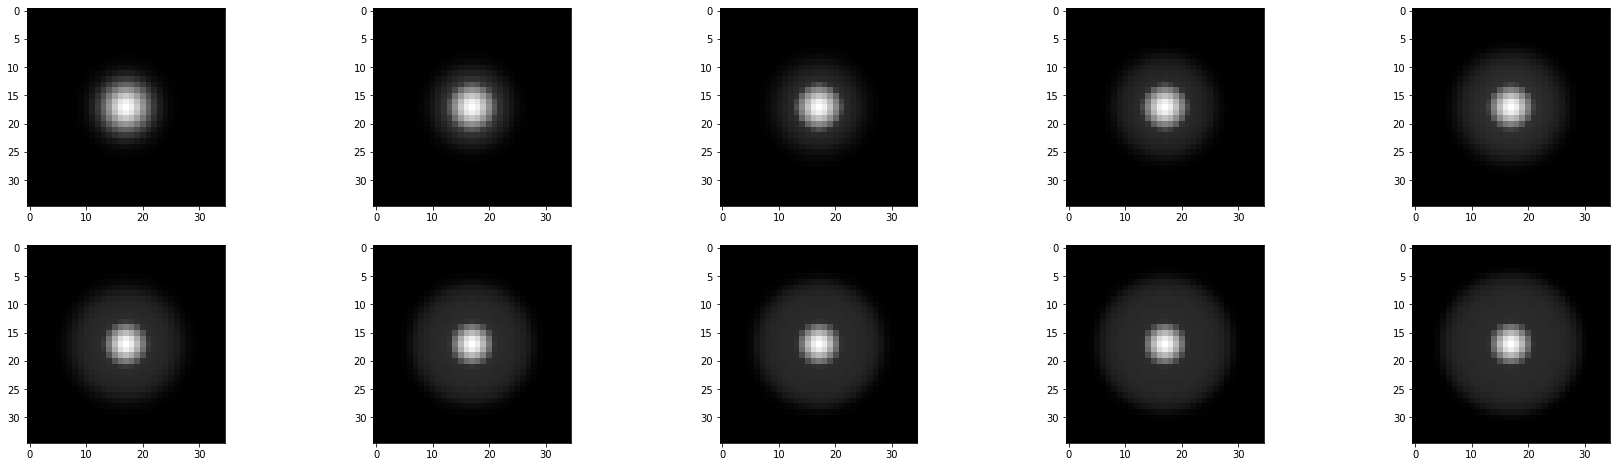

done


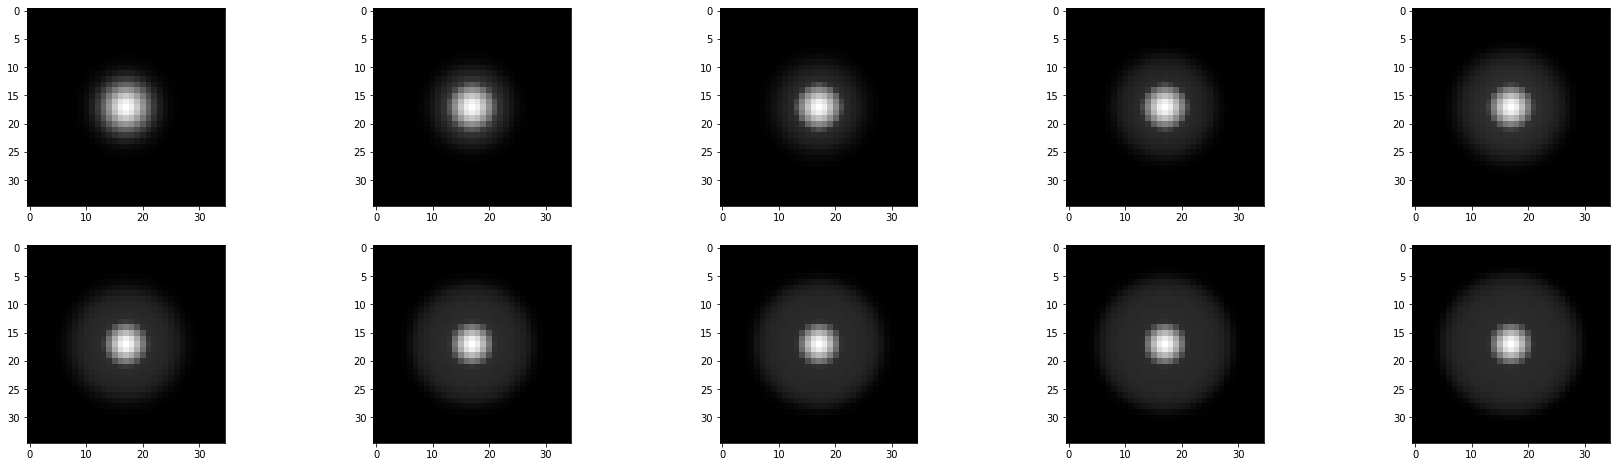

In [47]:
%matplotlib inline
gauss_img = create_img(gauss,sz=35,sigma=17.0)
sz = int(math.sqrt(len(gauss_img)))
fig, axes = plt.subplots(2,5,figsize=(30,8))
axes[0][0].imshow([[gauss_img[r*sz+c] for c in range(sz)] for r in range(sz)],cmap='gray')

from IPython import display
display.clear_output(wait=True)
display.display(plt.gcf())

count_arrows = ">"
for at in range(1,10):
    for iter in range(50):
        print("iteration" + count_arrows)
        count_arrows = count_arrows + ">"
        dS_dPixels = num_grad(lambda v:(mean_pixel_value_for_img(v)-0.5)**2
                    - entropy_for_img(v, bins_at, dump=False), gauss_img)    
        gauss_img = list(map(lambda px_dS:px_dS[0]-((1e-1)*px_dS[1]),
                            zip(gauss_img, dS_dPixels)))
    axes[at//5][at%5].imshow([[gauss_img[r*sz+c] for c in range(sz)] for r in range(sz)],cmap='gray')
    display.clear_output(wait=True)
    display.display(plt.gcf())

print("done")

In [28]:
for at in range(1,2):
    for iter in range(25):
        dS_dPixels = num_grad(lambda v:(mean_pixel_value_for_img(v)-0.5)**2
                    - entropy_for_img(v, bins_at, dump=False), gauss_img)
        # print("dS_dPixels = "); pprint.pprint(dS_dPixels)
        gauss_img = list(map(lambda px_dS:px_dS[0]-((1e-1)*px_dS[1]),
                            zip(gauss_img, dS_dPixels)))
        # print("next img = "); pprint.pprint(gauss_img)
    axes[at].imshow([[gauss_img[r*sz+c] for c in range(sz)] for r in range(sz)],cmap='gray')

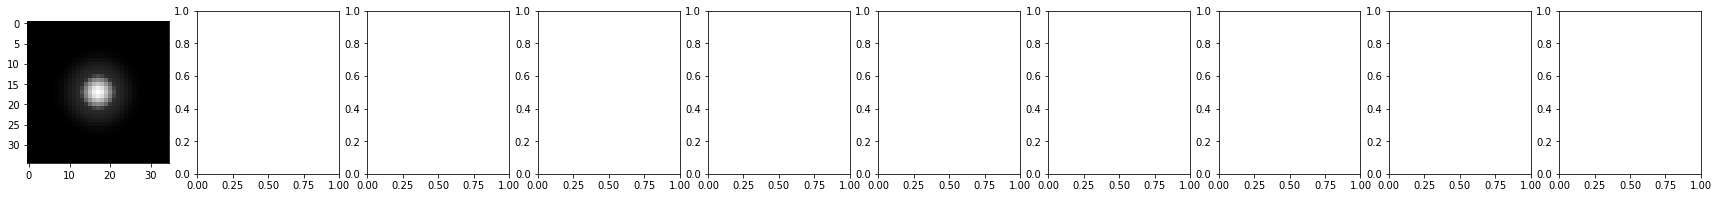

In [16]:
fig, axes = plt.subplots(1,10,figsize=(30,3))
# axes[0].imshow([[0,1,0],[1,0,1],[0,1,0]])
# axes[1].imshow([[0,1,0],[1,0,1],[0,1,0]])

# print("initial img (sz = {}= ".format(sz)); pprint.pprint(quad_img)
for at in range(10):
    for iter in range(50):
        dS_dPixels = num_grad(lambda v:(mean_pixel_value_for_img(v)-0.5)**2
                            - entropy_for_img(v, bins_at, dump=False), gauss_img)
        # print("dS_dPixels = "); pprint.pprint(dS_dPixels)
        gauss_img = list(map(lambda px_dS:px_dS[0]-((1e-1)*px_dS[1]),
                            zip(gauss_img, dS_dPixels)))
        # print("next img = "); pprint.pprint(gauss_img)
    axes[at].imshow([[gauss_img[r*sz+c] for c in range(sz)] for r in range(sz)],cmap='gray')

#pause(interval=1)

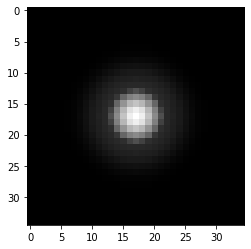

In [101]:
# print("initial img (sz = {}= ".format(sz)); pprint.pprint(quad_img)
for iter in range(50):
    dS_dPixels = num_grad(lambda v:(mean_pixel_value_for_img(v)-0.5)**2
                          - entropy_for_img(v, bins_at, dump=False), gauss_img)
    # print("dS_dPixels = "); pprint.pprint(dS_dPixels)
    gauss_img = list(map(lambda px_dS:px_dS[0]-((1e-1)*px_dS[1]),
                        zip(gauss_img, dS_dPixels)))
    # print("next img = "); pprint.pprint(gauss_img)
plt.imshow([[gauss_img[r*sz+c] for c in range(sz)] for r in range(sz)],cmap='gray')
#pause(interval=1)

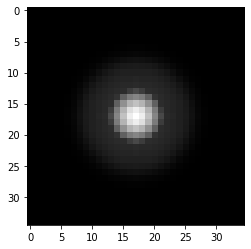

In [102]:
# print("initial img (sz = {}= ".format(sz)); pprint.pprint(quad_img)
for iter in range(50):
    dS_dPixels = num_grad(lambda v:(mean_pixel_value_for_img(v)-0.5)**2
                          - entropy_for_img(v, bins_at, dump=False), gauss_img)
    # print("dS_dPixels = "); pprint.pprint(dS_dPixels)
    gauss_img = list(map(lambda px_dS:px_dS[0]-((1e-1)*px_dS[1]),
                        zip(gauss_img, dS_dPixels)))
    # print("next img = "); pprint.pprint(gauss_img)
plt.imshow([[gauss_img[r*sz+c] for c in range(sz)] for r in range(sz)],cmap='gray')
#pause(interval=1)

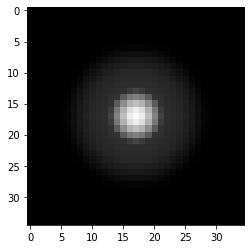

In [103]:
# print("initial img (sz = {}= ".format(sz)); pprint.pprint(quad_img)
for iter in range(50):
    dS_dPixels = num_grad(lambda v:(mean_pixel_value_for_img(v)-0.5)**2
                          - entropy_for_img(v, bins_at, dump=False), gauss_img)
    # print("dS_dPixels = "); pprint.pprint(dS_dPixels)
    gauss_img = list(map(lambda px_dS:px_dS[0]-((1e-1)*px_dS[1]),
                        zip(gauss_img, dS_dPixels)))
    # print("next img = "); pprint.pprint(gauss_img)
plt.imshow([[gauss_img[r*sz+c] for c in range(sz)] for r in range(sz)],cmap='gray')
#pause(interval=1)

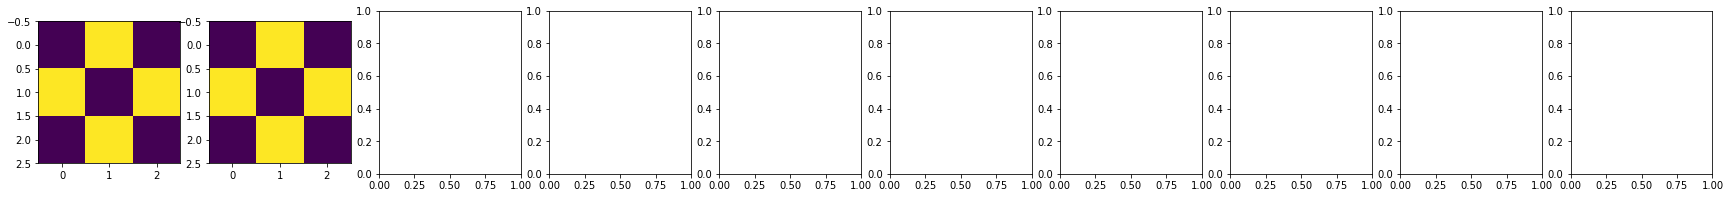

In [8]:
fig, axes = plt.subplots(1,10,figsize=(30,3))
axes[0].imshow([[0,1,0],[1,0,1],[0,1,0]])
axes[1].imshow([[0,1,0],[1,0,1],[0,1,0]])

In [82]:
#test that a uniform image has entropy >>> pixel count
#test that a dirac image has entropy >>> ???
#test that a gaussian image has entropy >>> ???
#test that shifting pixel values for an image doesn't (significantly) change entropy, as bins get narrower
#test d_Entropy / d_GaussWidth > 0.0

In [50]:
#optimize entropy from dirac
#optimize entropy from random
#optimize entropy of an arbitrary image